<a href="https://colab.research.google.com/github/iamviji/project/blob/master/PostMidTerm/Experiment/TensorFlow_Different_CostF_20_40_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
import numpy 
import time
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior ()
import matplotlib.pyplot as plt

In [69]:
SNR_BEGIN = 0
SNR_END = 10
SNR_STEP_SIZE = 0.5
NUM_OF_INPUT_MESSAGE = 1000
bler_per_iter_uncoded_commpy_psk_2= [0.521, 0.473, 0.436, 0.37,  0.304, 0.259, 0.187, 0.138, 0.098, 0.098, 0.052, 0.028, 0.012, 0.011, 0.009, 0.002, 0.0,  0.001, 0.,    0.0]
bler_per_iter_uncoded_itpp_psk_2= [0.518, 0.478, 0.415, 0.355, 0.305, 0.227, 0.177, 0.149, 0.11,  0.075, 0.055, 0.023, 0.014, 0.014, 0.015, 0.001, 0.003, 0.001, 0.,    0. ]
bler_per_iter_uncoded_commpy_psk_4 = [0.815, 0.793, 0.75,  0.714, 0.64,  0.639, 0.526, 0.49,  0.433, 0.371, 0.335, 0.236, 0.204, 0.154, 0.129, 0.08,  0.063, 0.046, 0.023, 0.018]
bler_per_iter_uncoded_itpp_psk_4 = [0.814, 0.767, 0.729, 0.702, 0.66,  0.616, 0.563, 0.511, 0.442, 0.4,   0.294, 0.277, 0.228, 0.17,  0.114, 0.087, 0.05,  0.037, 0.022, 0.017]
bler_per_iter_ldpc_itpp_psk_4 = [0.584, 0.488, 0.404, 0.332, 0.218, 0.151, 0.097, 0.058, 0.041, 0.024, 0.007, 0.004, 0.002, 0.001, 0.001, 0.,    0.,    0.,    0.,    0.,   ]
bler_per_iter_ham_itpp_psk_4= [0.51, 0.479, 0.419, 0.333, 0.313, 0.247, 0.212, 0.132, 0.114, 0.093, 0.042, 0.027, 0.024, 0.016, 0.006, 0.005, 0.003, 0.002, 0.,    0.  ]

In [70]:
# Helper Function
def bits2int(a, axis=-1):
    return numpy.right_shift(numpy.packbits(a, axis=axis), 8 - a.shape[axis]).squeeze()


def row_bits2int(arr):
    n = arr.shape[1]  # number of columns
    # shift the bits of the first column to the left by n - 1
    a = arr[:, 0] << n - 1  

    for j in range(1, n):
        # "overlay" with the shifted bits of the next column
        a |= arr[:, j] << n - 1 - j  
    return a

def Snr2Sigma(snr):
  sigma = 10 ** (- snr / 20)
  return sigma

def timer_update(i,current,time_tot,tic_incr=500):
    last = current
    current = time.time()
    t_diff = current-last
    print('SNR: {:04.3f} - Iter: {} - Last {} iterations took {:03.2f}s'.format(snr,i+1,tic_incr,t_diff))
    return time_tot + t_diff

In [79]:
# ARCH 2 : 18-36-18
NUM_OF_INPUT_MESSAGE = 10000
channel_size = 20
input_message_length = 20
num_hidden_1 = 2 * channel_size
print(num_hidden_1) 
print ("input_message_length=", input_message_length, "channel_size", channel_size)

input_message_x = tf.placeholder("float32", [None, input_message_length], name="input_message_x")
input_message_x_decimal = tf.placeholder("float32", [None], name="input_message_x_decimal")
awgn_noise_std_dev_x = tf.placeholder("float32", name ="awgn_noise_std_dev")
input_channel_x = tf.placeholder("float32", [None, 2 * channel_size], name="input_channel_x")

weights = {
  "encoder_l1" : tf.Variable (tf.random_uniform([input_message_length, 2*input_message_length], -1, 1), name="encoder_l1_weights"),
  "encoder_l2" : tf.Variable (tf.random_uniform([2*input_message_length, num_hidden_1], -1, 1), name="encoder_l2_weights"),
  "decoder_l1" : tf.Variable (tf.random_uniform([num_hidden_1, 2*input_message_length], -1, 1), name="decoder_l1_weights"),
  "decoder_l2" : tf.Variable (tf.random_uniform([2*input_message_length, input_message_length], -1, 1), name="decoder_l2_weights"),
}

biases = {
  "encoder_l1" : tf.Variable (tf.random_uniform([2*input_message_length], -1,1), name="encoder_l1_bias"),
  "encoder_l2" : tf.Variable (tf.random_uniform([num_hidden_1], -1,1), name="encoder_l2_bias"),
  "decoder_l1" : tf.Variable (tf.random_uniform([2*input_message_length], -1,1), name="decoder_l1_bias"),
  "decoder_l2" : tf.Variable (tf.random_uniform([input_message_length], -1,1), name="decoder_l2_bias"),
}

def dl_encoder (x):
  layer_1 = tf.nn.tanh (tf.matmul(x, weights['encoder_l1']) + biases['encoder_l1'])
  layer_2 = tf.nn.tanh (tf.matmul(layer_1, weights['encoder_l2']) + biases['encoder_l2'])
  #layer_2 = tf.round(layer_1)
  layer_3 =  layer_2 / tf.sqrt(tf.reduce_mean(tf.square(layer_2)))
  #layer_2 =  tf.nn.relu(layer_1)
  return layer_3

def dl_decoder (x):
  layer_1 = tf.nn.tanh (tf.matmul(x, weights['decoder_l1']) + biases['decoder_l1'])
  layer_2 = tf.nn.sigmoid (tf.matmul(layer_1, weights['decoder_l2']) + biases['decoder_l2'])
  return layer_2

def awgn_layer(x):
  awgn_noise = tf.random.normal(tf.shape(x), stddev=awgn_noise_std_dev_x,  name="awgn_noise")
  awgn_channel_output = tf.add(x, awgn_noise, name ="x_and_noise")
  return awgn_channel_output


dl_encoder_output = dl_encoder(input_message_x)
dl_decoder_input = awgn_layer(dl_encoder_output)
#awgn_noise = tf.random.normal(tf.shape(dl_encoder_output), stddev=awgn_noise_std_dev,  name="awgn_noise")
#dl_decoder_input = tf.add(dl_encoder_output, awgn_noise, name ="x_and_noise")
dl_decoder_output = dl_decoder (dl_decoder_input)
dl_decoder_only_output = dl_decoder(input_channel_x)

#tried
#loss1 = tf.reduce_mean (-1 * (input_message_x*tf.log(dl_decoder_output) + (1 - input_message_x)*tf.log(1 - dl_decoder_output) ))

#loss1 = tf.reduce_mean (tf.sqrt(tf.reduce_sum(tf.square(input_message_x-dl_decoder_output), axis=1)))

loss1 = tf.reduce_mean ((tf.reduce_sum(tf.square(input_message_x-dl_decoder_output), axis=1)))

dl_decoder_output_decimal = tf.reduce_sum(
    tf.cast(tf.reverse(tensor=dl_decoder_output, axis=[0]), dtype=tf.int32)
    * 2 ** tf.range(tf.cast(tf.size(dl_decoder_output), dtype=tf.int32)))
dl_decoder_output_decimal = tf.cast(dl_decoder_output_decimal, dtype=tf.float32)
#loss1 = tf.reduce_mean (tf.square(dl_decoder_output_decimal - input_message_x_decimal))

lr = tf.placeholder(dtype=tf.float32,shape=[])
opt = tf.train.AdamOptimizer(learning_rate=lr).minimize (loss1)


awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [2*channel_size])
awgn_noise_std_dev = tf.placeholder(tf.float64)
awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)

40
input_message_length= 20 channel_size 20


In [80]:
training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
print (training_input_message)
print (len(training_input_message))

[[0 1 0 ... 0 1 1]
 [0 0 0 ... 1 0 1]
 [0 0 1 ... 1 1 0]
 ...
 [0 1 0 ... 1 0 1]
 [1 0 0 ... 1 1 0]
 [1 1 0 ... 0 0 1]]
100000


In [73]:
training_input_message_decimal = []
for i in range (NUM_OF_INPUT_MESSAGE*10):
  val = 0
  for j in range (input_message_length):
    val = val + training_input_message [i][j] * pow(2, j)
  training_input_message_decimal.append(val)
print (training_input_message_decimal)


[1002539, 780445, 594884, 810267, 724590, 144119, 17270, 261253, 625293, 993976, 374863, 759082, 143035, 554937, 282415, 326763, 944059, 473778, 276710, 957205, 1018412, 329517, 357714, 1038, 149226, 260427, 933120, 82103, 937064, 184268, 799756, 717596, 911760, 345529, 575061, 69892, 364426, 274569, 1019355, 882411, 674722, 720463, 662525, 563156, 635701, 680622, 874356, 853723, 389449, 999078, 294541, 537154, 54729, 521538, 418519, 352227, 568185, 472187, 179907, 804029, 183659, 955280, 900436, 10375, 496148, 75402, 897272, 783284, 26336, 1001289, 679671, 104962, 63974, 63579, 897424, 880385, 518416, 131274, 785768, 109629, 665874, 837013, 446594, 718171, 354220, 808263, 984944, 16327, 507237, 35941, 390254, 849843, 433919, 996398, 128152, 658182, 14264, 296378, 391824, 379123, 785003, 615185, 542143, 297150, 402711, 735131, 779895, 784693, 796687, 858313, 799731, 248766, 110683, 948286, 217766, 757196, 778007, 1008267, 247294, 1006884, 36313, 924525, 899196, 671984, 453158, 931455, 

In [81]:
batch_size = 500


# Training
train_init = tf.global_variables_initializer ()
train_sess = tf.Session ()

epochs = 50
outer_ephocs = 1
num_of_batches = len(training_input_message) / batch_size
display_step = 400
print ("batch_size:", batch_size, "num_of_batcches:", num_of_batches)
train_sess.run(train_init)
l = 0
lrate = 0.05
i = 0
for oe in range(outer_ephocs):
  for snr in (numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)):
    sigma = 1.0*Snr2Sigma (snr)
    print ("Training for SNR=", snr, " sigma=", sigma) 
    for e in range(epochs):
      for j in range (int(num_of_batches)):
        i = i + 1
        k = e * epochs + j
        x_train_batch = training_input_message [j*batch_size:(j+1)*batch_size]
        x_train_batch_float = x_train_batch.astype("float32")
        _, l = train_sess.run ([opt, loss1], feed_dict={input_message_x:x_train_batch_float, awgn_noise_std_dev_x:sigma, lr:lrate})
        if (l < 0.5): lrate = 0.01
        if (l < 0.25): lrate = 0.0001
        if (l < 0.1): lrate = 0.00001
        if k % display_step == 0:
          print('Step %i: Minibatch Loss: %f' % (i, l))

batch_size: 500 num_of_batcches: 200.0
Training for SNR= 0.0  sigma= 1.0
Step 1: Minibatch Loss: 7.844979
Step 1151: Minibatch Loss: 1.360741
Step 1301: Minibatch Loss: 1.395946
Step 1451: Minibatch Loss: 1.238253
Step 1601: Minibatch Loss: 1.330156
Step 2751: Minibatch Loss: 1.298740
Step 2901: Minibatch Loss: 1.316836
Step 3051: Minibatch Loss: 1.386021
Step 3201: Minibatch Loss: 1.383013
Step 4351: Minibatch Loss: 1.336503
Step 4501: Minibatch Loss: 1.404325
Step 4651: Minibatch Loss: 1.443081
Step 4801: Minibatch Loss: 1.358776
Step 5951: Minibatch Loss: 1.336435
Step 6101: Minibatch Loss: 1.330267
Step 6251: Minibatch Loss: 1.365277
Step 6401: Minibatch Loss: 1.356118
Step 7551: Minibatch Loss: 1.313228
Step 7701: Minibatch Loss: 1.377912
Step 7851: Minibatch Loss: 1.373853
Step 8001: Minibatch Loss: 1.358108
Step 9151: Minibatch Loss: 1.411290
Step 9301: Minibatch Loss: 1.386861
Step 9451: Minibatch Loss: 1.389928
Step 9601: Minibatch Loss: 1.424765
Training for SNR= 0.5  sigma= 

In [75]:
# Here I am using trained model
NUM_OF_INPUT_MESSAGE_BER = 1000
output_display_counter = NUM_OF_INPUT_MESSAGE_BER/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

channel_in = []
channel_out = []
for snr in numpy.arange (0, 10, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE_BER):
    input_message_xx = training_input_message [i:i+1]
    input_message_xx_float = input_message_xx.astype("float32")
    encoded_message = train_sess.run ([dl_encoder_output], feed_dict={input_message_x:input_message_xx_float})
    #print (encoded_message[0][0])
    channel_in.append(encoded_message[0][0])
    #print (encoded_message[0][0])
    awgn_channel_output_message = train_sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message[0][0]})
    channel_out.append(awgn_channel_output_message[0]) 
    #print (awgn_channel_output_message[0])
    decoded_message = train_sess.run ([dl_decoder_only_output], feed_dict={input_channel_x:awgn_channel_output_message})
    #print ("input", input_message[i])
    decoded_message = numpy.around(decoded_message[0][0]).astype(int)
    #print ("output", decoded_message)
    if abs(decoded_message-training_input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE_BER
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.39s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.65s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.92s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 1.19s
SNR: 0.000:
 -> BER: 0.81
 -> Total Time: 3.14s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.27s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.53s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.80s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 1.06s
SNR: 0.500:
 -> BER: 0.76
 -> Total Time: 2.66s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.26s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.54s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.80s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 1.07s
SNR: 1.000:
 -> BER: 0.71
 -> Total Time: 2.67s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.26s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.53s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

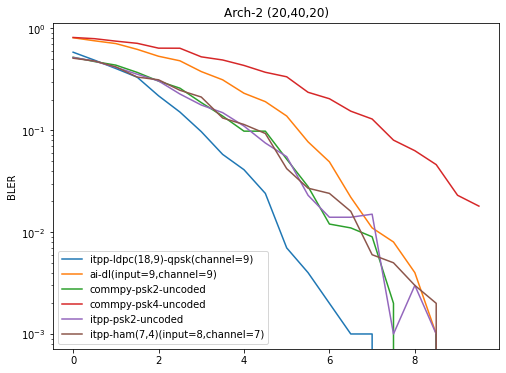

In [76]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,bler_per_iter_ldpc_itpp_psk_4,'', label="itpp-ldpc(18,9)-qpsk(channel=9)") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl(input=9,channel=9)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2,'', label="commpy-psk2-uncoded") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="commpy-psk4-uncoded") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="itpp-psk2-uncoded") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="itpp-ham(7,4)(input=8,channel=7)") # plot BER vs SNR
ax1.set_ylabel('BLER')
ax1.set_title('Arch-2 ({},{},{})'.format(input_message_length,2*input_message_length, channel_size))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(2*channel_size,input_message_length))
plt.legend ()
plt.show()

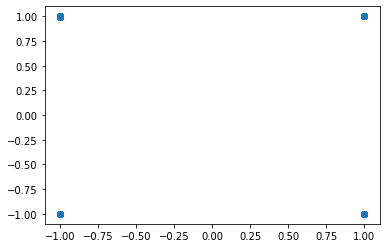

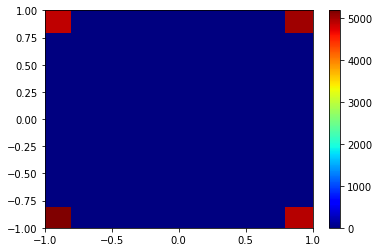

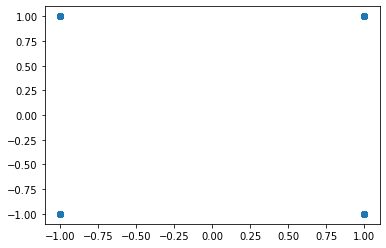

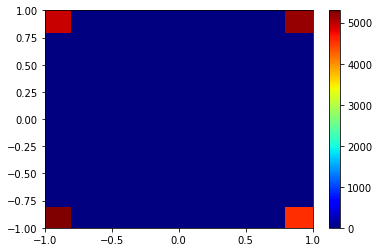

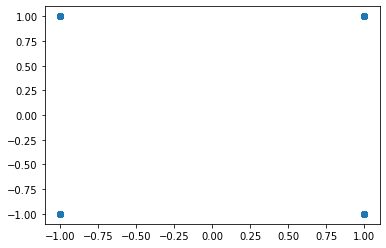

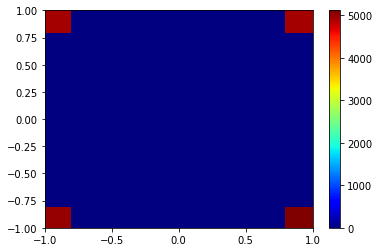

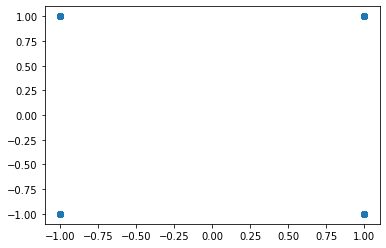

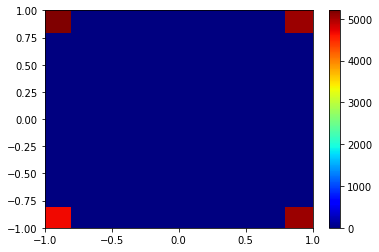

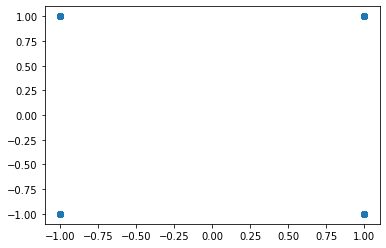

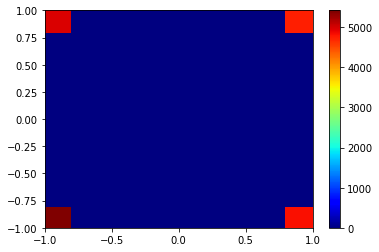

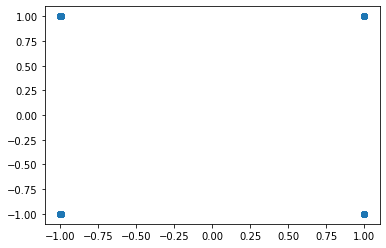

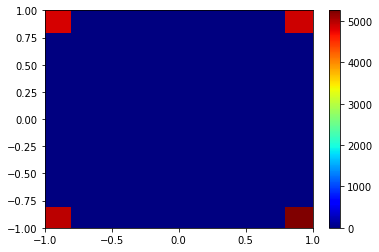

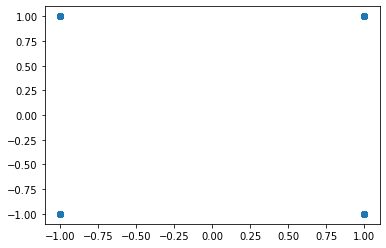

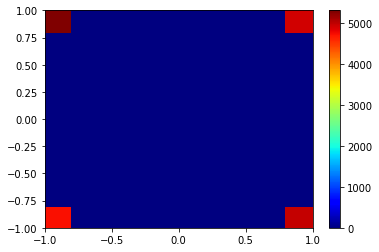

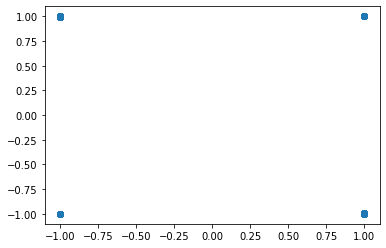

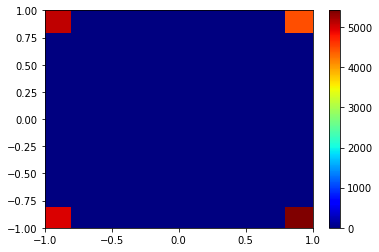

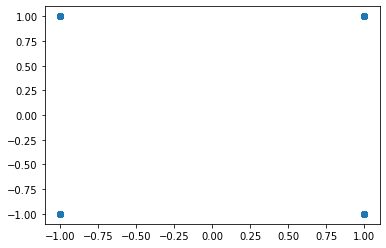

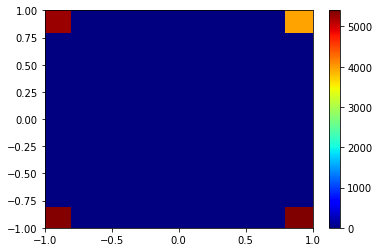

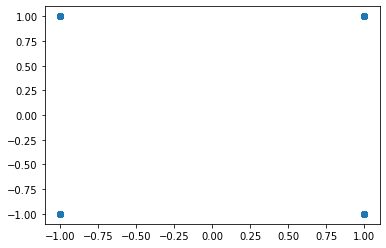

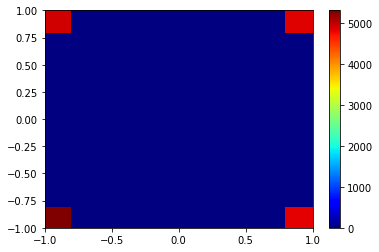

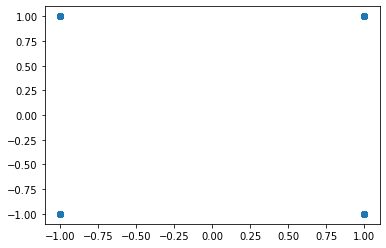

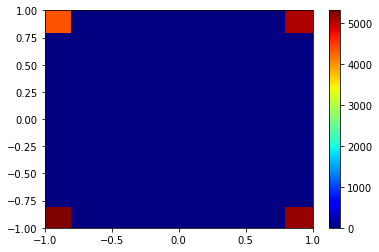

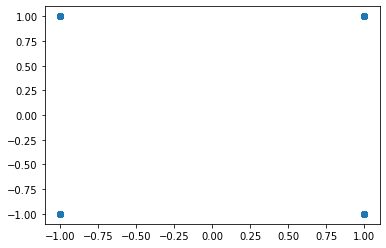

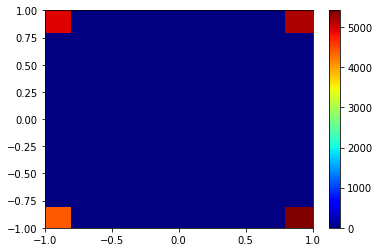

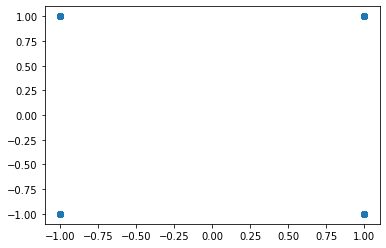

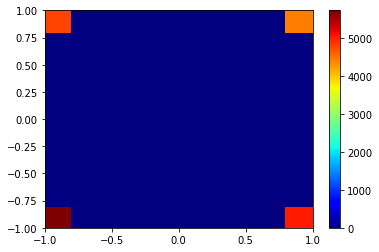

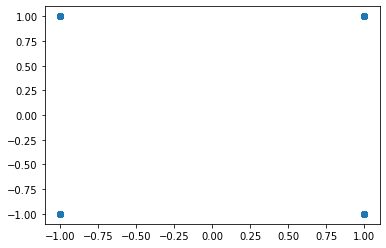

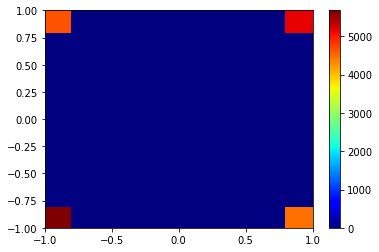

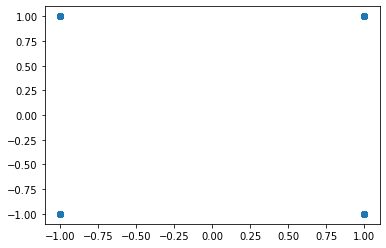

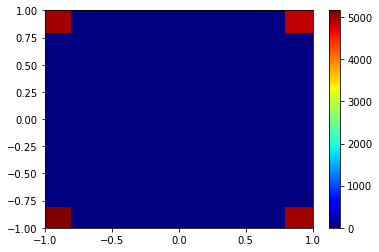

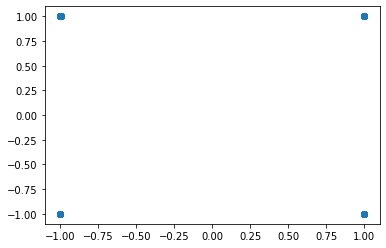

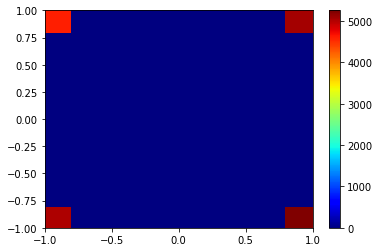

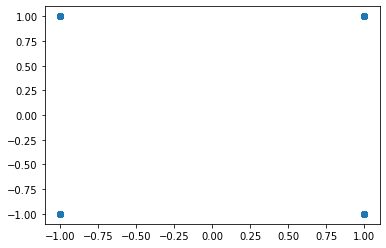

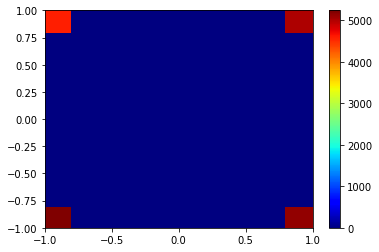

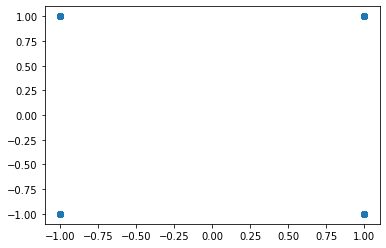

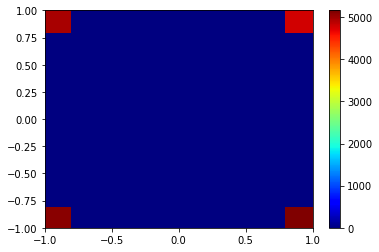

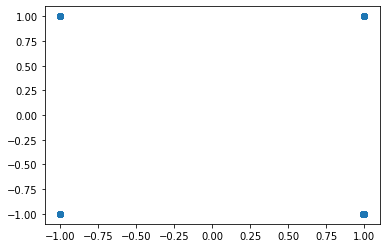

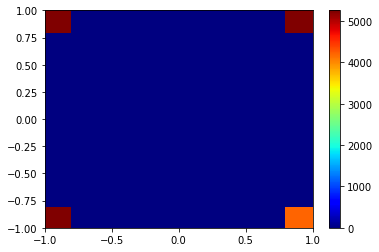

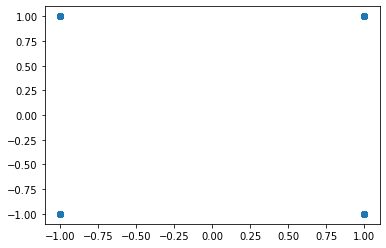

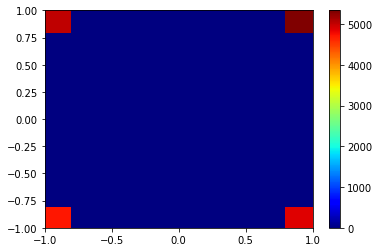

In [77]:
import matplotlib.pyplot as plt
channel_in_array = numpy.transpose(channel_in)

for i in range (int(channel_size)):
  plt.scatter(channel_in_array[i*2], channel_in_array[i*2+1])
  plt.show()
  plt.hist2d(channel_in_array[i*2], channel_in_array[i*2+1], cmap=plt.cm.jet)
  plt.colorbar()
  plt.show()

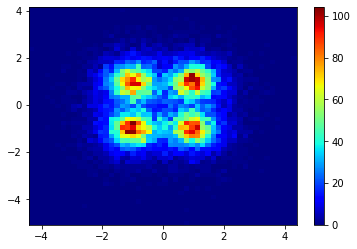

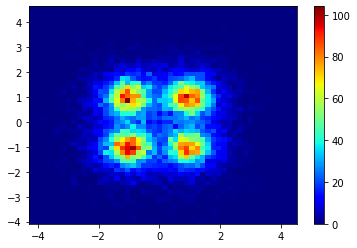

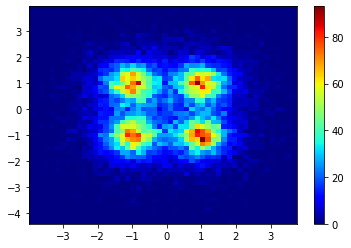

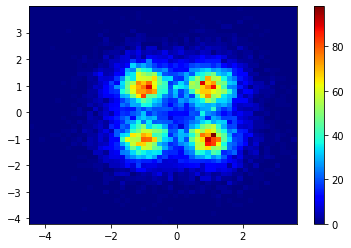

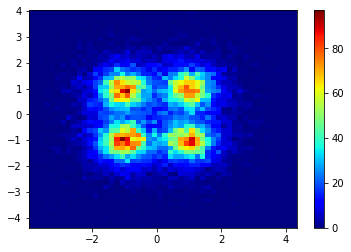

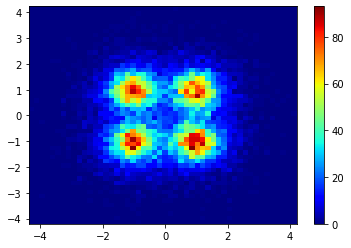

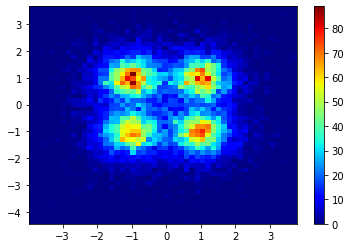

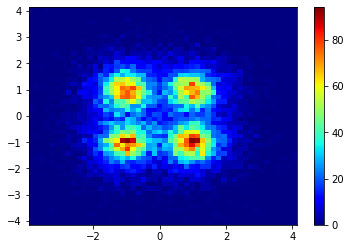

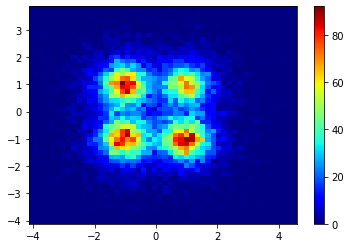

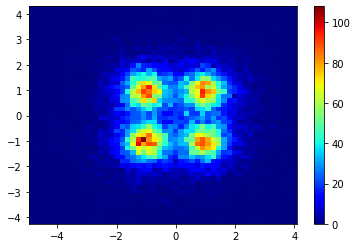

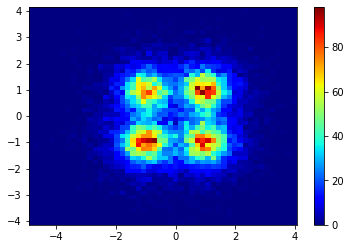

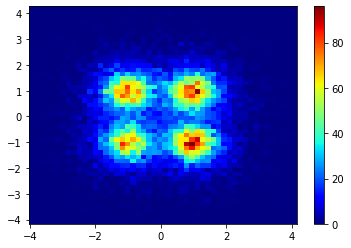

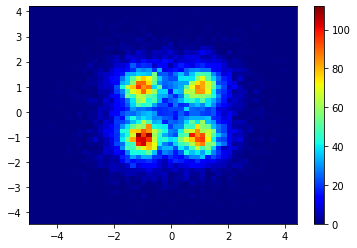

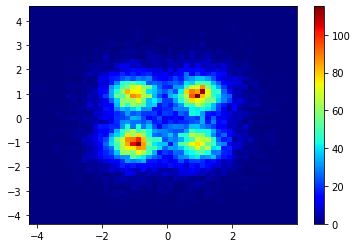

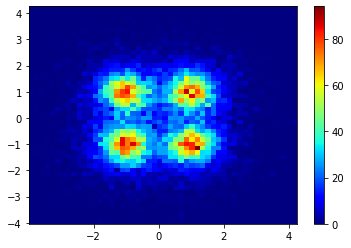

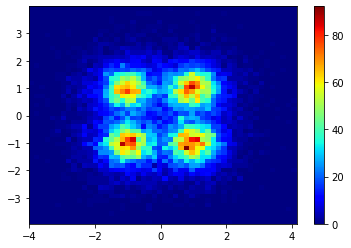

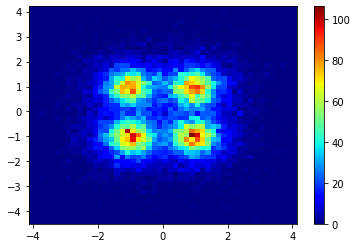

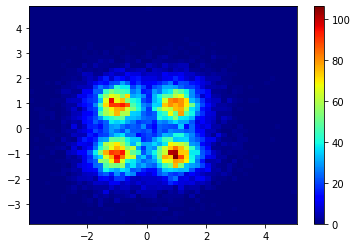

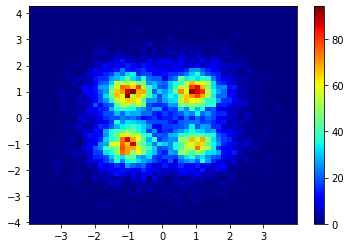

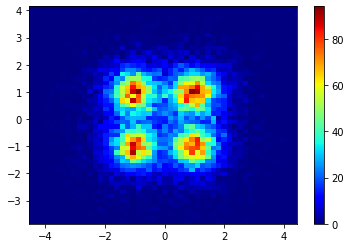

In [78]:
channel_out_array = numpy.transpose(channel_out)

for i in range (int(channel_size)):
  plt.hist2d(channel_out_array[2*i], channel_out_array[2*i+1], (50, 50), cmap=plt.cm.jet)
  plt.colorbar()
  plt.show()